In [48]:
library(Seurat)
library(ggplot2)
library(readxl)
library(ggsci)
library(cowplot)
library(stringr)
library(ggrepel)
library(tidyverse)
library(viridis)
library(data.table)
library(cowplot)
library(ComplexHeatmap)

clustercols <- readRDS("colorList.rds")
set.seed(123)

In [2]:
################## Subset cells with new filter ##########################
new_srt_filter <- readRDS("srt_postfilter_NEW_percentmt_10.rds")
new_srt_subset <- subset(new_srt_filter, source == "Lung")
dim(new_srt_subset)
table(new_srt_subset$source_tp)

old_srt_subset <- readRDS("srt_subset_lung.rds")
srt_subset <- old_srt_subset[,colnames(new_srt_subset)]
dim(srt_subset)
table(srt_subset$source_tp)

[1] 32285 26902


 Lung_D0 Lung_D21 
   20356     6546 

[1] 32285 26902


 Lung_D0 Lung_D21 
   20356     6546 

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


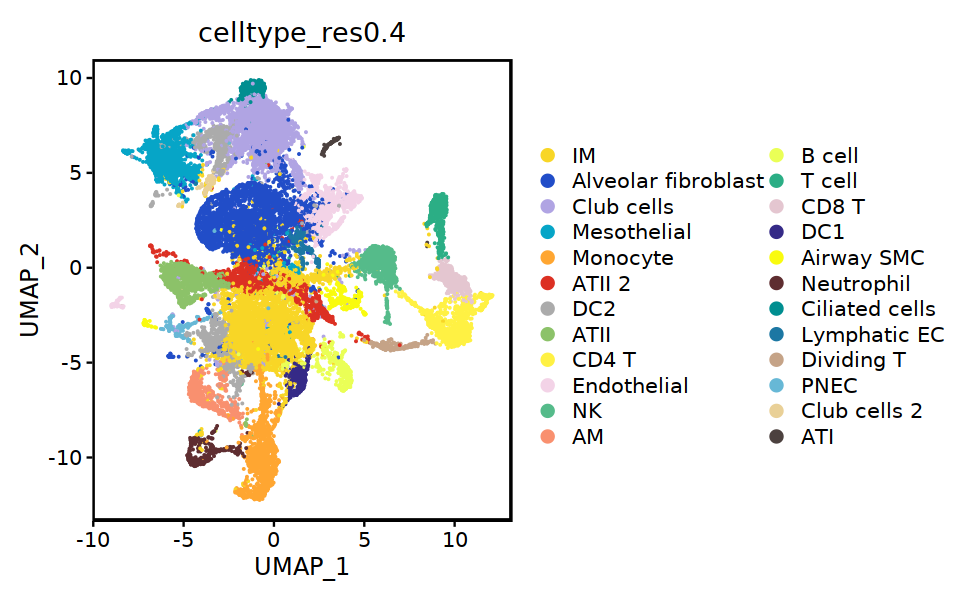

In [3]:
# Plot UMAP with new filtered dataset
width = 8
height = 5
options(repr.plot.width=width, repr.plot.height=height)
p3 <- DimPlot(srt_subset, label = F, reduction ="umap", group.by = "celltype_res0.4", cols=clustercols[-c(18:27)], raster=F) + 
theme(panel.background = element_rect(colour = "black", size=1), axis.line = element_blank()) 
# ggplot2::ggsave(plot = p3,  filename = "umap_res0.4_pc22_celltype_nolabel.pdf",  device = 'pdf', width = width, height = height,  units = "in")
p3

In [ ]:
############### Re-cluster the cells ######################################
srt_subset <- NormalizeData(srt_subset, display.progress = FALSE)
srt_subset <- FindVariableFeatures(srt_subset, do.plot = F, display.progress = FALSE)
srt_subset = ScaleData(srt_subset, display.progress = FALSE,  features = rownames(srt_subset))
srt_subset <- RunPCA(object = srt_subset, verbose = FALSE)
ElbowPlot(srt_subset, ndims = 50)
DimHeatmap(srt_subset, dims = 24:35, cells = 500, balanced = TRUE) 

In [118]:
# Testing different clustering parameters (save separately) then add clusters into srt meta data
test <- FindNeighbors(object = srt_subset, dims = 1:22)
test <- FindClusters(object = test, resolution = 0.4)
unique(test$seurat_clusters)
width = 8
height = 7
options(repr.plot.width=width, repr.plot.height=height)
UMAPPlot(test, label=T) +  
  scale_color_manual(values=clustercols) +
  theme(panel.background = element_rect(colour = "black", size=0.8), axis.line = element_blank()) 

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 25622
Number of edges: 817528

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9384
Number of communities: 27
Elapsed time: 2 seconds


[1] 1  2  22 0  5  16 12 19 18 9  10 3  21 7  13 6  8  17 14 15 11 24 4  23 25
[26] 26 20
27 Levels: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 ... 26

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 25622
Number of edges: 817528

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9384
Number of communities: 27
Elapsed time: 2 seconds


[1] 1  2  22 0  5  16 12 19 18 9  10 3  21 7  13 6  8  17 14 15 11 24 4  23 25
[26] 26 20
27 Levels: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 ... 26

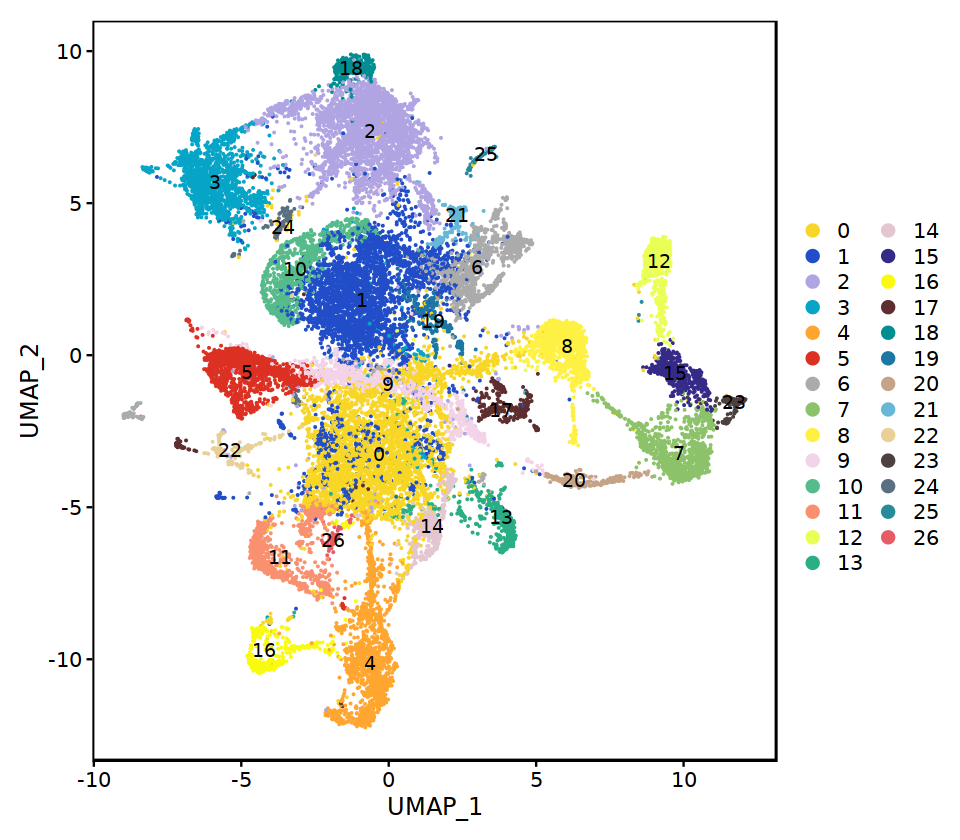

In [132]:
# Run clustering with parameters on srt_subset
srt_subset <- FindNeighbors(object = srt_subset, dims = 1:22)
srt_subset <- FindClusters(object = srt_subset, resolution = 0.4)
unique(srt_subset$seurat_clusters)
width = 8
height = 7
options(repr.plot.width=width, repr.plot.height=height)
UMAPPlot(srt_subset, label=T) +  
  scale_color_manual(values=clustercols[-c(18:27)]) +
  theme(panel.background = element_rect(colour = "black", size=0.8), axis.line = element_blank()) 
saveRDS(srt_subset, "srt_subset_lung_NEW.rds")

In [ ]:
srt_subset <readRDS("srt_subset_lung_NEW.rds")

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


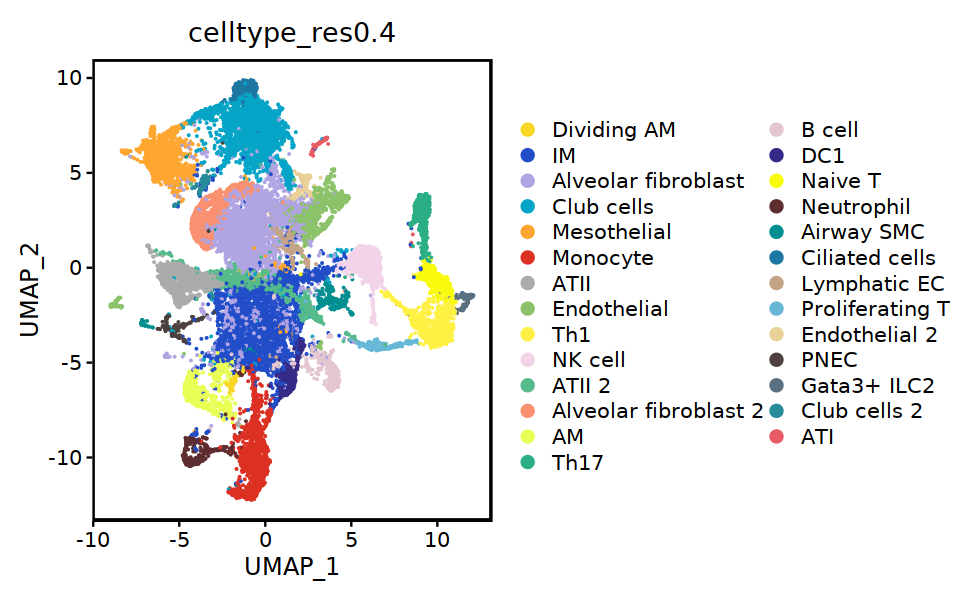

In [ ]:
width = 8
height = 5
options(repr.plot.width=width, repr.plot.height=height)
p3 <- DimPlot(srt_subset, label = F, reduction ="umap", group.by = "celltype_res0.4", cols=clustercols[-c(18:27)], raster=F) + 
theme(panel.background = element_rect(colour = "black", size=1), axis.line = element_blank()) 
# ggplot2::ggsave(plot = p3,  filename = "umap_res0.4_pc22_celltype_nolabel.pdf",  device = 'pdf', width = width, height = height,  units = "in")
p3

In [10]:
################# From here, subclustering ########################
## Look at DC2 -> the cells are all over the place
srt_subset_specific_clust <-  subset(srt_subset,  celltype_res0.4 == 'DC2')

In [12]:
table(srt_subset_specific_clust$source_tp)


 Lung_D0 Lung_D21 
    1408       83 

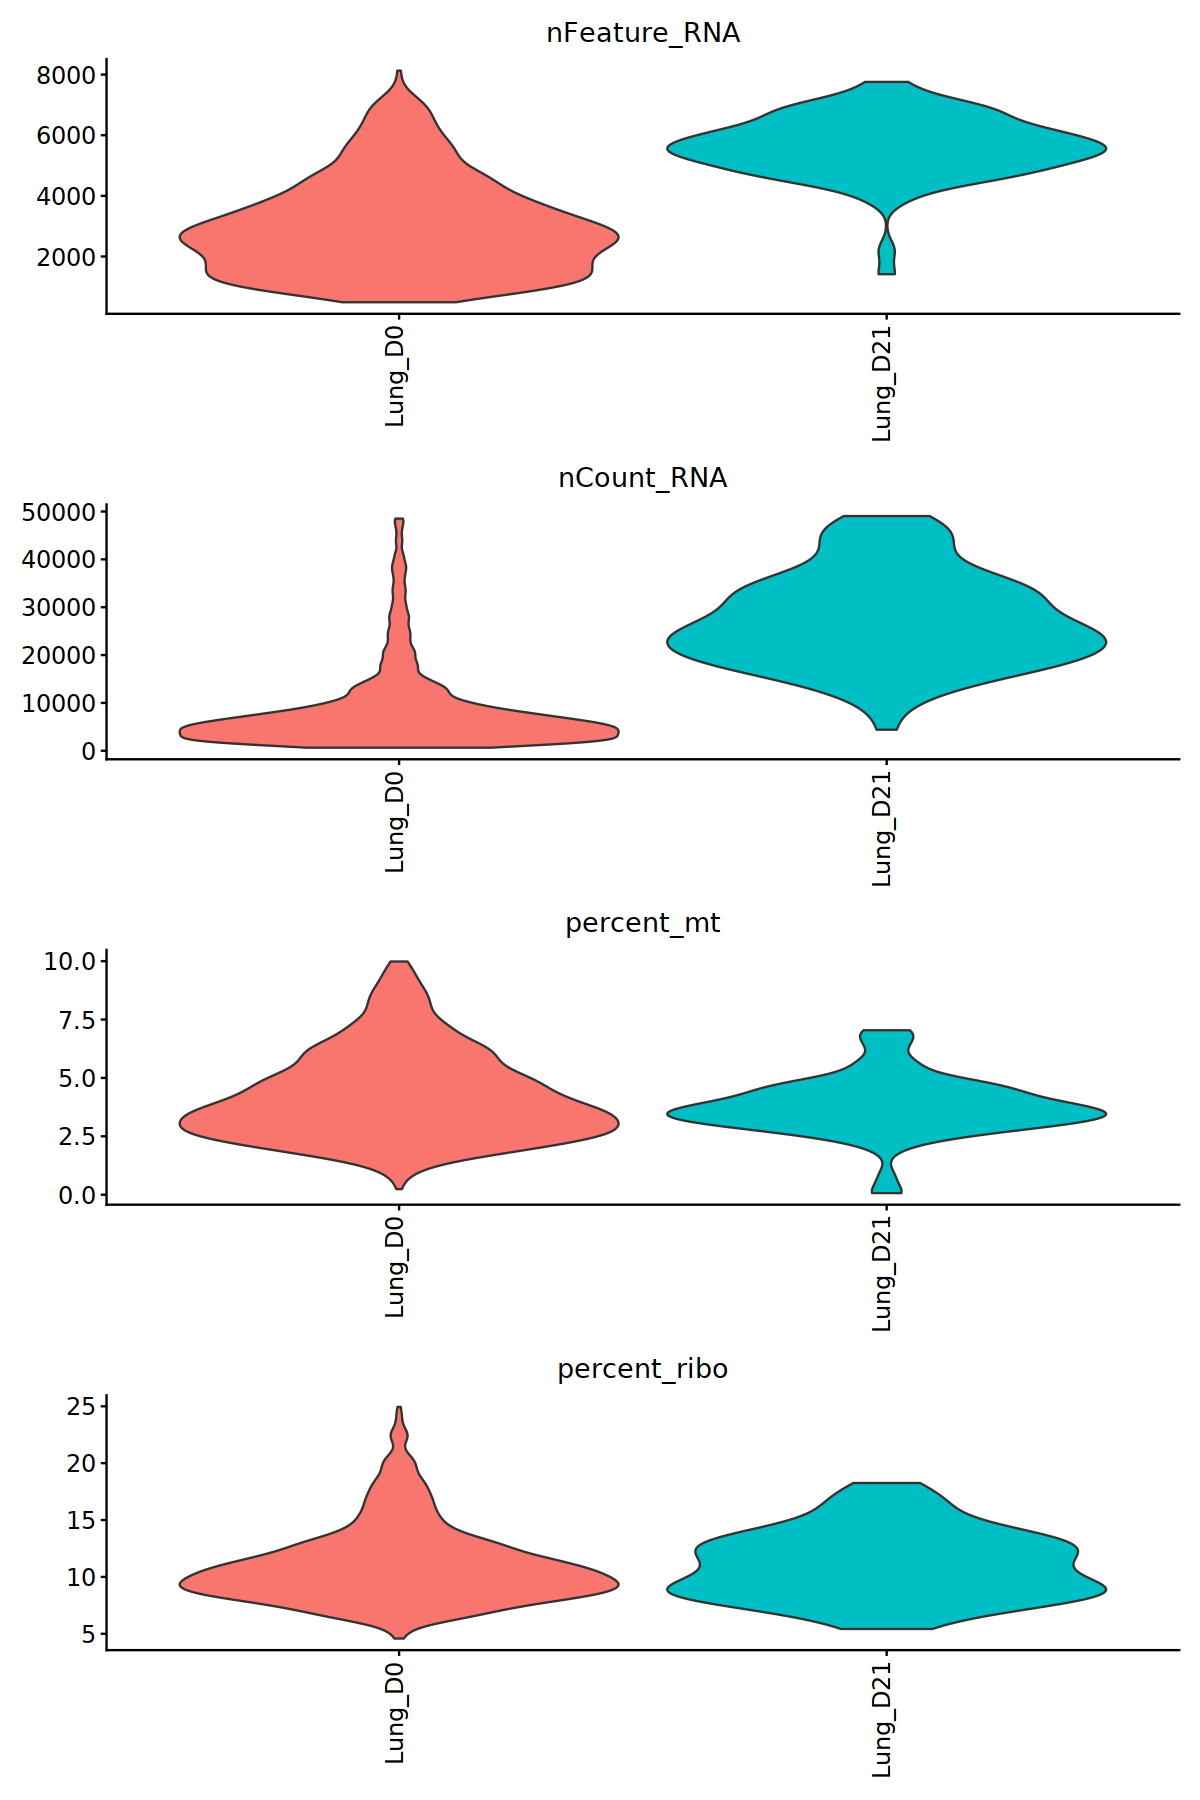

In [16]:
################# Check specific cluster QC ########################
width = 10
height = 15
options(repr.plot.width=width, repr.plot.height=height)

p = VlnPlot(srt_subset_specific_clust, 
            features = c("nFeature_RNA", "nCount_RNA", "percent_mt", "percent_ribo"),
            raster = F, group.by = "source_tp", #col=zeileis_28,
            ncol = 1 , pt.size = 0) &
  # scale_y_continuous(trans='log2', n.breaks=60) &
  # scale_y_continuous(trans='log2') &
  # ylim(0, 50000) &
  theme(axis.title.x = element_blank(), 
        axis.text.y=element_text(size = 14, face="bold"),
        axis.text.x=element_text(size = 14, angle = 90, hjust = 0.95, vjust=0.2, face="bold"), 
        axis.title=element_text(size=16,face="bold")) 
print(p)

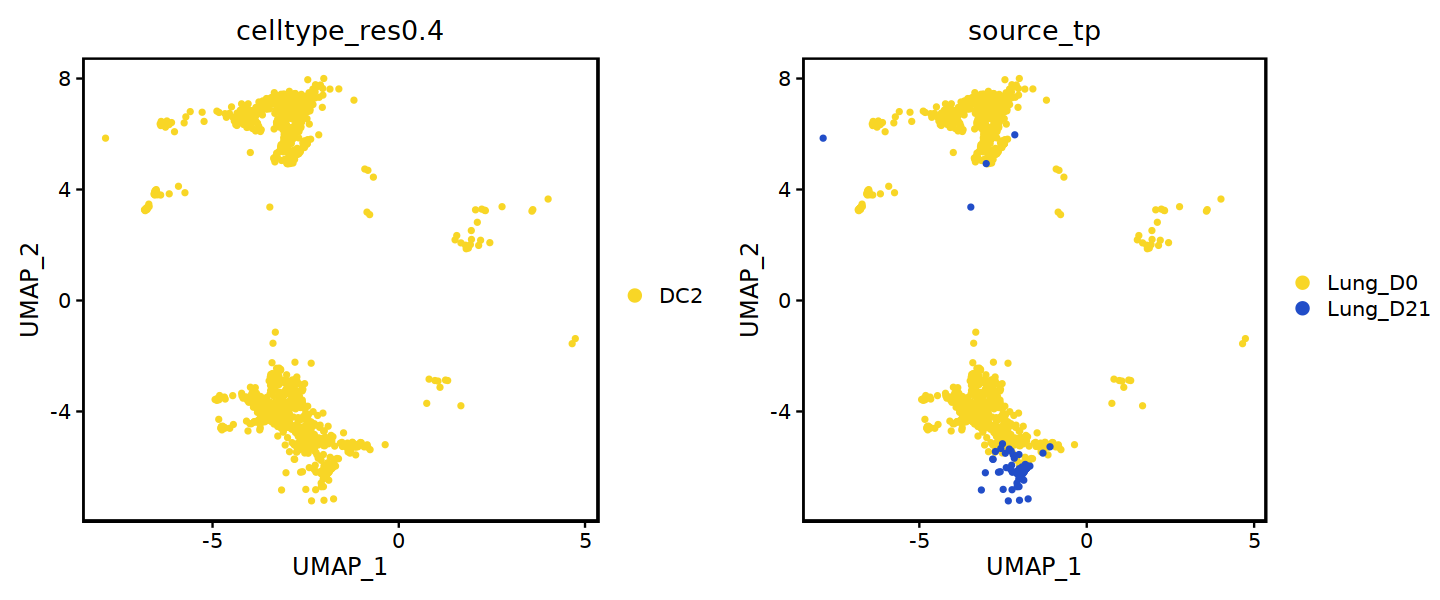

In [21]:
width = 12
height = 5
options(repr.plot.width=width, repr.plot.height=height)

p1 <- DimPlot(srt_subset_specific_clust, label = F, reduction ="umap", group.by = "celltype_res0.4", cols=clustercols[-c(18:27)], raster=F) + 
theme(panel.background = element_rect(colour = "black", size=1), axis.line = element_blank()) 
p2 <- DimPlot(srt_subset_specific_clust, label = F, reduction ="umap", group.by = "source_tp", cols=clustercols[-c(18:27)], raster=F) + 
theme(panel.background = element_rect(colour = "black", size=1), axis.line = element_blank()) 

plot_grid(p1, p2)

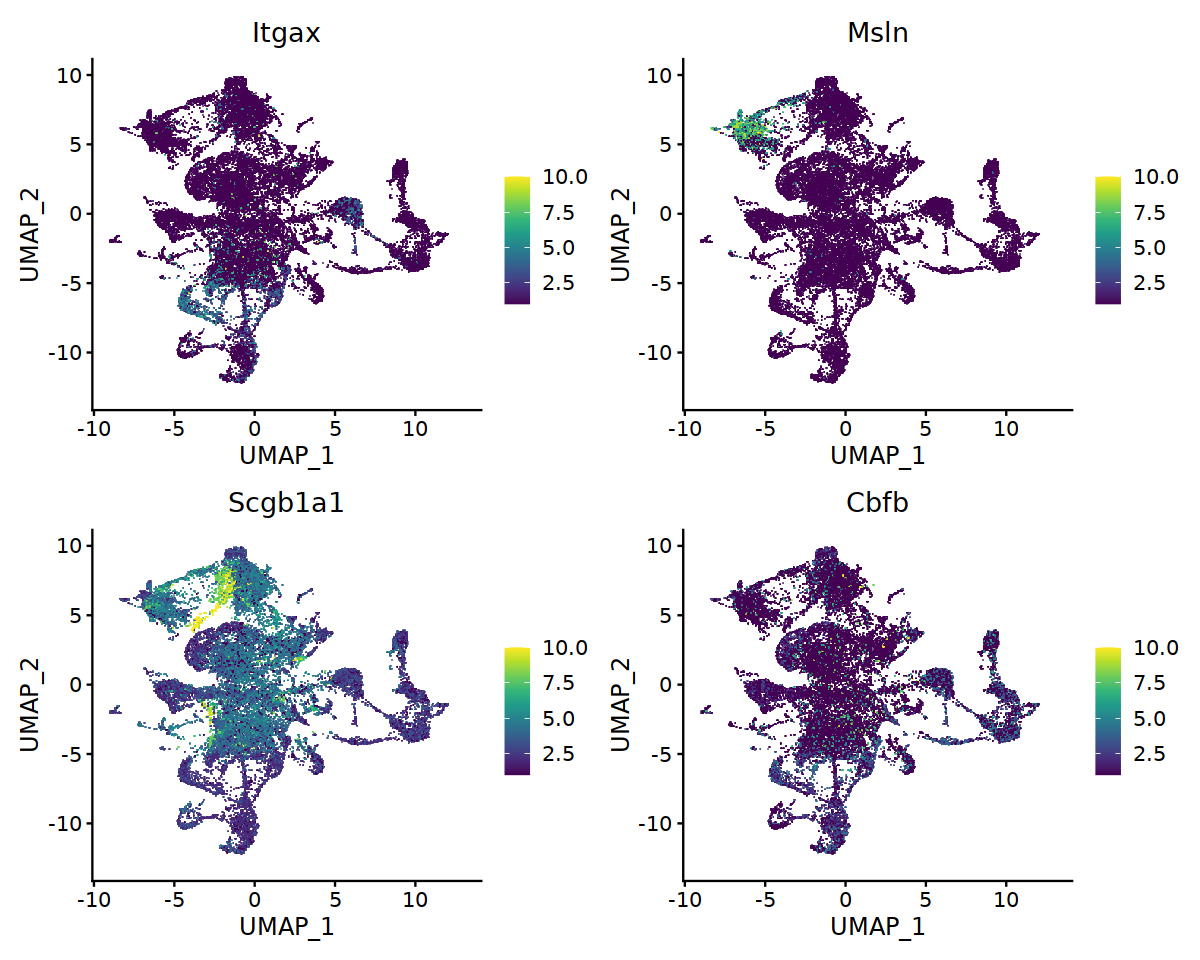

In [246]:
width = 10
height = 8
options(repr.plot.width=width, repr.plot.height=height)

FeaturePlot(srt_subset, features = c("Itgax", "Msln", "Scgb1a1", "Cbfb"), raster=T, cols =viridis(10))

In [ ]:
# Subcluster the specific cluster
srt_subset_specific_clust <- RunPCA(object = srt_subset_specific_clust, verbose = FALSE)
ElbowPlot(srt_subset_specific_clust, ndims = 50)
DimHeatmap(srt_subset_specific_clust, dims = 24:35, cells = 500, balanced = TRUE) 
srt_subset_specific_clust <- FindNeighbors(object = srt_subset_specific_clust, dims = 1:12)
srt_subset_specific_clust <- FindClusters(object = srt_subset_specific_clust, resolution = 0.3)
unique(srt_subset_specific_clust$seurat_clusters)
srt_subset_specific_clust <- RunUMAP(object = srt_subset_specific_clust, dims = 1:23)

width = 7
height = 5
options(repr.plot.width=width, repr.plot.height=height)
UMAPPlot(srt_subset_specific_clust, label=T) +  
  scale_color_manual(values=clustercols) +
  theme(panel.background = element_rect(colour = "black", size=0.8), axis.line = element_blank()) 

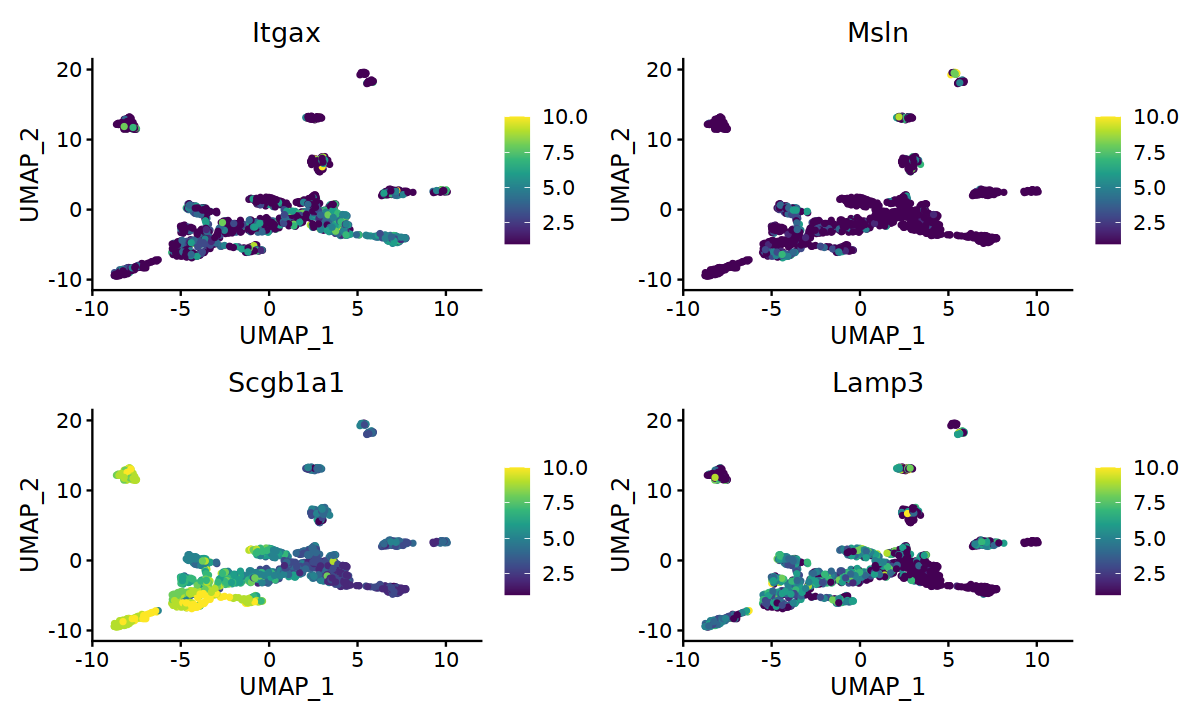

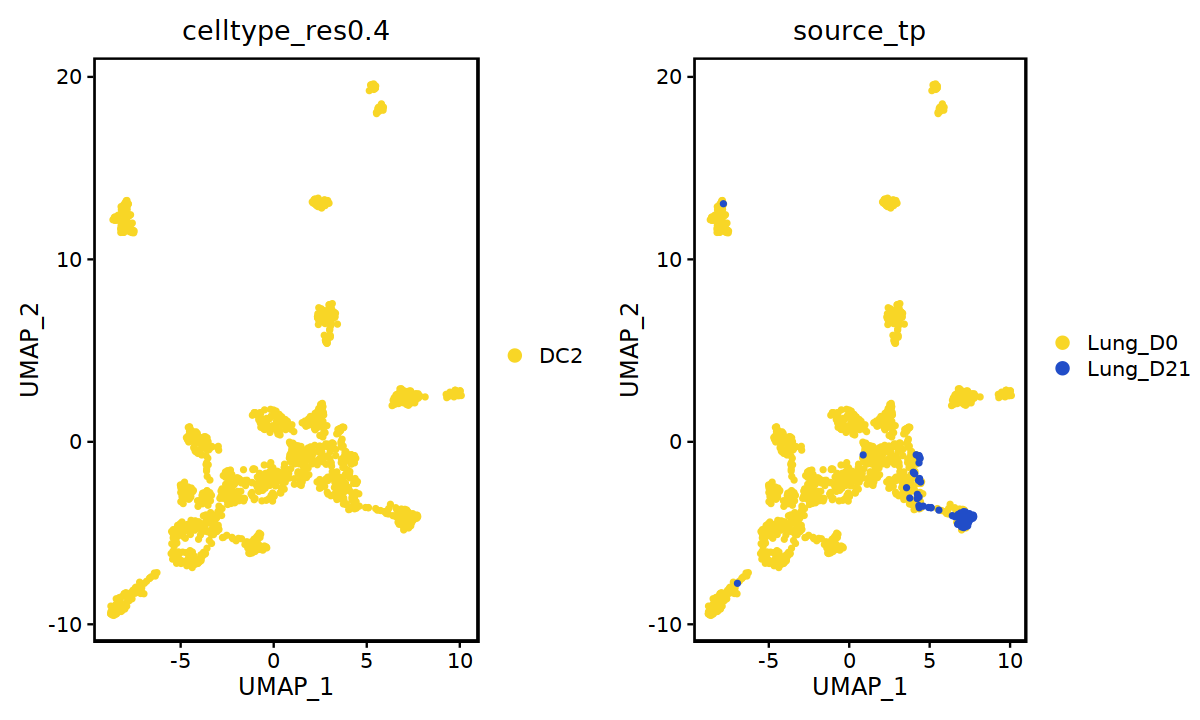

In [36]:
width = 10
height = 6
options(repr.plot.width=width, repr.plot.height=height)
FeaturePlot(srt_subset_specific_clust, features = c("Itgax", "Msln", "Scgb1a1", "Lamp3"), cols =viridis(10))

p1 <- DimPlot(srt_subset_specific_clust, label = F, reduction ="umap", group.by = "celltype_res0.4", cols=clustercols[-c(18:27)], raster=F) + 
theme(panel.background = element_rect(colour = "black", size=1), axis.line = element_blank()) 
p2 <- DimPlot(srt_subset_specific_clust, label = F, reduction ="umap", group.by = "source_tp", cols=clustercols[-c(18:27)], raster=F) + 
theme(panel.background = element_rect(colour = "black", size=1), axis.line = element_blank()) 
plot_grid(p1, p2)

In [ ]:
p = VlnPlot(srt_subset_specific_clust, 
            features = c("nFeature_RNA", "nCount_RNA", "percent_mt", "percent_ribo"),
            # features = c("nFeature_RNA", "nCount_RNA", "percent_ribo"),
            # features = c("nFeature_RNA"),
            # raster = F, group.by = "source_tp", 
            raster = F, group.by = "seurat_clusters",
            ncol = 1 , pt.size = 0) &
  # scale_y_continuous(trans='log2', n.breaks=60) &
  # scale_y_continuous(trans='log2') &
  # ylim(0, 50000) &
  theme(axis.title.x = element_blank(), 
        axis.text.y=element_text(size = 14, face="bold"),
        axis.text.x=element_text(size = 14, angle = 90, hjust = 0.95, vjust=0.2, face="bold"), 
        axis.title=element_text(size=16,face="bold")) 
print(p)

In [37]:
# Differential expresison of the DC2 subclusters
################ FindMarkers for D21vsD0 for each cluster ##################)

scDEG=function(srt, group1, group2, fc=0.25, pctcutoff=0.1) {
  res1=FindMarkers(srt, ident.1 = group1, ident.2 = group2, verbose = T, test.use="wilcox", logfc.threshold = fc, min.pct=pctcutoff)
  res1$gene=rownames(res1)
  res1=as.data.table(res1, keep.rownames = F)
  res1$cell1=sum(srt@active.ident %in% group1)
  res1$cell2=sum(srt@active.ident %in% group2)
  res1$contrast1=group1
  res1$contrast2=group2
  return(res1)
}

fc=-Inf #fc=-Inf  to return all markers
pctcutoff=-Inf  #pctcutoff=-Inf to return all markers

srt_subset_specific_clust = subset(srt_subset_specific_clust, features=names(which(rowSums(srt_subset@assays$RNA@counts)>0)))   #only keep genes that are expressed 

srt_subset_specific_clust$varToCompare = paste0(srt_subset_specific_clust$seurat_clusters, "_",  srt_subset_specific_clust$timepoint)
Idents(srt_subset_specific_clust) <- "varToCompare"

group1_tp <- "D21"
group2_tp <- "D0"

deg_result = NULL
for(celltype_id in unique(srt_subset_specific_clust$seurat_clusters)) {
  if(sum(srt_subset_specific_clust@meta.data$varToCompare == paste0(celltype_id, "_" , group1_tp)) < 10 |   #if we have < 10 cells we skip
     sum(srt_subset_specific_clust@meta.data$varToCompare == paste0(celltype_id, "_", group2_tp)) < 10) {next}
  res = scDEG(srt=srt_subset_specific_clust,
            group1=paste0(celltype_id, "_" , group1_tp),
            group2=paste0(celltype_id, "_", group2_tp),
            fc=fc, pctcutoff=pctcutoff)
  res$celltype=celltype_id
  deg_result = rbind(deg_result, res)
}

saveRDS(deg_result, file="DC2_subclusters_lung_fcInf_pctInf_D21vsD0_DEG_allGenes.rds")

In [59]:
fwrite(deg_result, file="DC2_subclusters_lung_fcInf_pctInf_D21vsD0_DEG_allGenes.csv")

In [65]:
# Get countplot
data.frame(table(srt_subset_specific_clust$varToCompare))

Var1,Freq
<fct>,<int>
0_D0,425
0_D21,1
1_D0,387
1_D21,1
10_D0,29
2_D0,110
2_D21,23
3_D0,107
4_D0,92


In [62]:
Idents(srt_subset_specific_clust) <- "seurat_clusters"
unique(Idents(srt_subset_specific_clust))

[1] 4  0  1  3  8  9  7  2  5  6  10
Levels: 0 1 2 3 4 5 6 7 8 9 10

In [ ]:
### Get variable genes of subclusters
srtmarkers_specific_clust <- FindAllMarkers(srt_subset_specific_clust, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
head(srtmarkers_specific_clust)
top5 <- srtmarkers_specific_clust %>% group_by(cluster) %>% top_n(n = 8, wt = avg_log2FC)
dim(top5)

In [70]:
# Plot average expression of FindAllMarkers for each subcluster
tmp = AverageExpression(srt_subset_specific_clust, group.by="seurat_clusters", features = top5$gene, slot = 'data')$RNA
# colnames(tmp) = str_c("C", colnames(tmp))

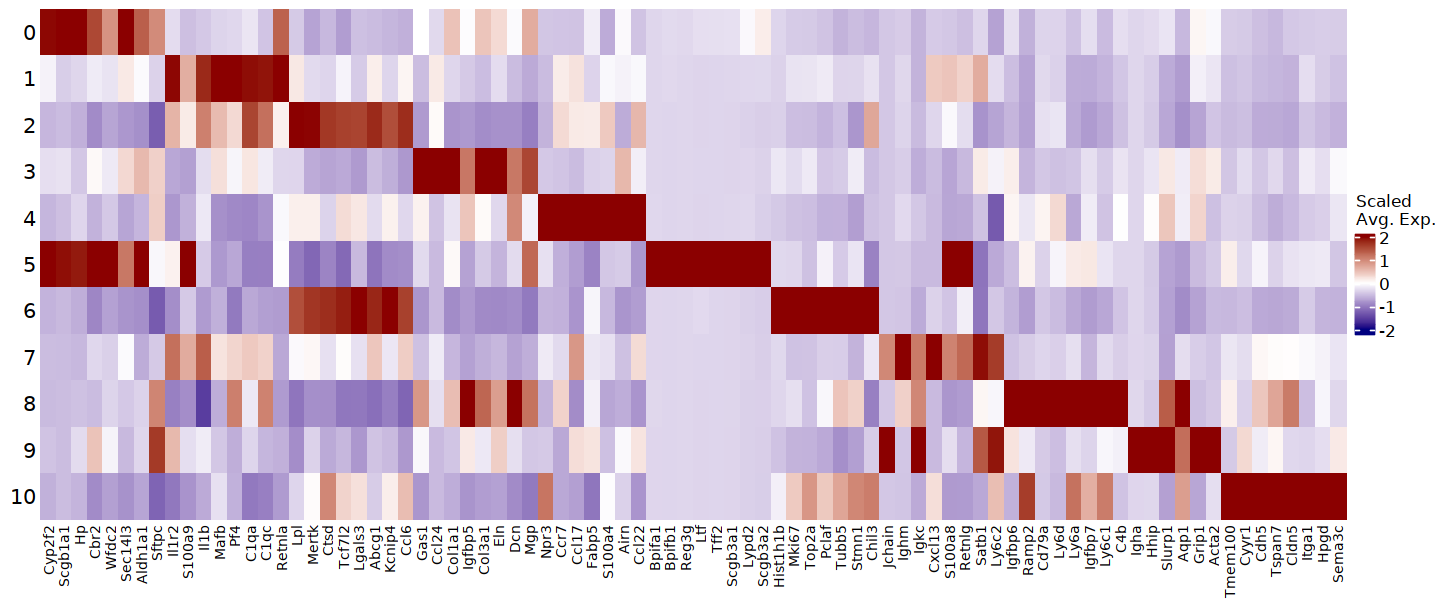

In [73]:
width = 12
height = 5
#library(scales)
options(repr.plot.width=width, repr.plot.height=height)
col_fun = circlize::colorRamp2(c(-2, 0, 2), c("navyblue", "white", "darkred"))

ht = Heatmap(scale(t(tmp)), name="Scaled \nAvg. Exp.", col=col_fun,
             cluster_rows = FALSE,
             cluster_columns = FALSE, 
             column_names_side = 'bottom',
             row_names_side="left",
             column_names_rot = 90,
             column_names_gp = gpar(fontsize = 8, fontface = "bold"),
             row_names_gp = gpar(fontsize = 12, fontface = "bold"),
             # rect_gp = gpar(col = "white", lwd = 2),
             # cell_fun = function(j, i, x, y, w, h, col) { # add text to each grid
             # grid.text(scales::percent(cellpct[i, j], 0.01), x, y)}
            )

draw(ht)
# pdf(paste0("top5_markers_heatmap_avg.pdf"), width = width, height = height)
# draw(ht)
# dev.off()

In [84]:
# Filter out DC2 weird clusters from dataset
clust_to_remove <- subset(srt_subset_specific_clust, idents = c(2,6), invert=TRUE)

In [87]:
table(clust_to_remove$seurat_clusters)
dim(clust_to_remove)


  0   1   2   3   4   5   6   7   8   9  10 
426 388   0 107  93  79   0  72  45  41  29 

[1] 25676  1280

In [89]:
dim(srt_subset)

[1] 32285 26902

In [92]:
srt_subset <- subset(srt_subset, cells=colnames(clust_to_remove), invert=TRUE)

In [94]:
saveRDS(srt_subset, "srt_subset_lung_NEW.rds") 
# use seurat_clusters for updated clustering (nclust=28)

In [52]:
srt_subset <- readRDS("srt_subset_lung_NEW.rds")

In [293]:
Idents(srt_subset) <- srt_subset$`celltype_res0.4`
clustcolfinal <- clustercols[-c(14:30)][-c(23:33)][1:length(levels(Idents(srt_subset)))]
names(clustcolfinal) <- levels(Idents(srt_subset))

In [295]:
saveRDS(clustcolfinal, "clustcolfinal.rds")

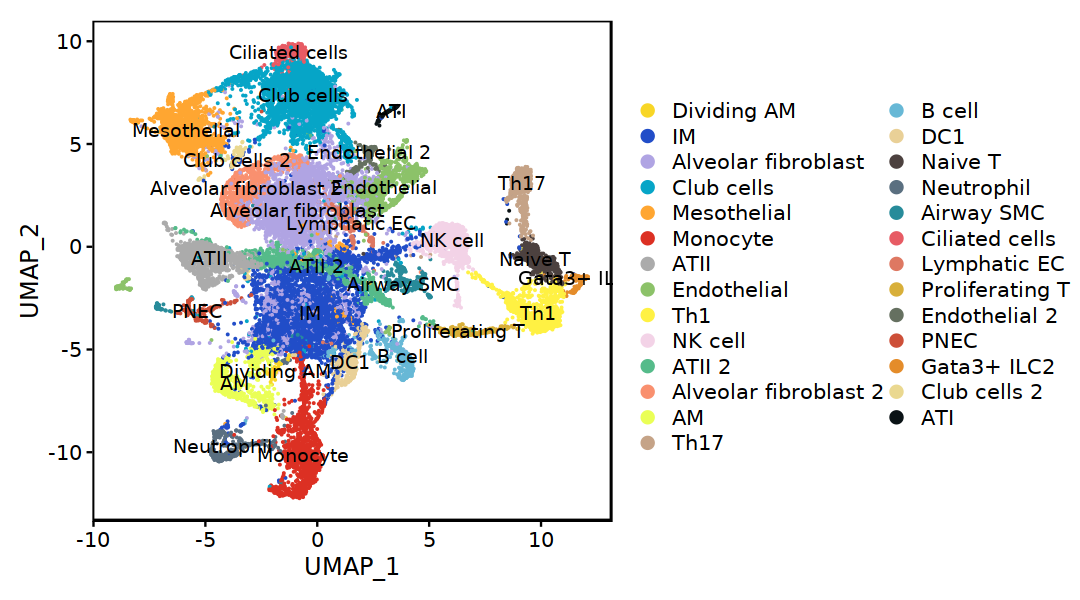

In [296]:
width = 9
height = 5
options(repr.plot.width=width, repr.plot.height=height)
p <- UMAPPlot(srt_subset, label=T) +  
  scale_color_manual(values=clustcolfinal) +
  theme(panel.background = element_rect(colour = "black", size=0.8), axis.line = element_blank()) 
ggplot2::ggsave(plot = p,  filename = "UMAP_NEW_wlabel.pdf",  device = 'pdf', width = width, height = height,  units = "in")
p

In [129]:
srt_subset <- readRDS("srt_subset_lung_NEW.rds")

In [114]:
Idents(srt_subset) <- "seurat_clusters"

In [115]:
unique(Idents(srt_subset))

[1] 2  1  19 0  9  14 11 3  7  4  5  12 10 16 13 8  15 17 6  18
Levels: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19

In [125]:
srt_subset$varToCompare = paste0(srt_subset$`celltype_res0.4`, "_",  srt_subset$timepoint)
data.frame(table(srt_subset$varToCompare))

Var1,Freq
<fct>,<int>
Airway SMC_D0,377
Airway SMC_D21,33
Alveolar fibroblast_D0,3560
Alveolar fibroblast_D21,372
AM_D0,155
AM_D21,584
ATI_D0,83
ATI_D21,17
ATII 2_D0,1177


In [ ]:
### Get variable genes of subclusters
variableMarkers <- FindAllMarkers(srt_subset, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
head(variableMarkers)
top5 <- variableMarkers %>% group_by(cluster) %>% top_n(n = 8, wt = avg_log2FC)
dim(top5)

In [174]:
fwrite(variableMarkers, "variable_markers_clust_res0.4_NEW.csv")

In [224]:
# Plot average expression of FindAllMarkers for each subcluster
tmp = AverageExpression(srt_subset, group.by="celltype_res0.4", features = top5$gene, slot = 'data')$RNA
# colnames(tmp) = str_c("C", colnames(tmp))

In [227]:
width = 15
height = 7
#library(scales)
options(repr.plot.width=width, repr.plot.height=height)
col_fun = circlize::colorRamp2(c(-2, 0, 2), c("navyblue", "white", "darkred"))

ht = Heatmap(scale(t(tmp)), name="Scaled \nAvg. Exp.", col=col_fun,
             cluster_rows = FALSE,
             cluster_columns = FALSE, 
             column_names_side = 'bottom',
             row_names_side="left",
             column_names_rot = 90,
             column_names_gp = gpar(fontsize = 6),
             row_names_gp = gpar(fontsize = 12),
             # rect_gp = gpar(col = "white", lwd = 2),
             # cell_fun = function(j, i, x, y, w, h, col) { # add text to each grid
             # grid.text(scales::percent(cellpct[i, j], 0.01), x, y)}
            )

draw(ht)
pdf(paste0("top8_markers_heatmap_avg.pdf"), width = width, height = height)
draw(ht)
dev.off()

png 
  2

In [ ]:
width = 9
height = 7
options(repr.plot.width=width, repr.plot.height=height)

p <- FeaturePlot(srt_subset, features = c("Cbfb","Gata3", "Tbx21", "Rorc"), raster=T, cols =viridis(10))
# ggplot2::ggsave(plot = p,  filename = "featureplot_ISGs_1.pdf",  device = 'pdf', width = width, height = height,  units = "in")
p

In [171]:
width = 14
height = 14
options(repr.plot.width=width, repr.plot.height=height)
p1 <- FeaturePlot(srt_subset, features = c("Ptprc", "Cd3e",  "Cd8a", "Cd4", "Gzmb",
                                     "Rorc", "Tbx21", "Gata3",  #Th17, Th1, Th2 
                                     "Tcrg-V6",
                                     "Pax5", #B cell
                                     "Itgax",  "Xcr1",  "Flt3",  #DC
                                     "Fcgr1",  #myeloid
                                     "Itgam", "Ms4a3",  "Lyz1", "Lyz2", "Fcna",  #monocyte
                                     "Pltp", "Mertk",  #interstitial macro
                                     "Trem1", #AM
                                     "Kit", "Ms4a2"  #mast cell
                                    ),  cols =viridis(10), raster=T)
ggplot2::ggsave(plot = p1,  filename = "featureplot1_res0.4_pc22.pdf",  device = 'pdf', width = width, height = height,  units = "in")

p2 <- FeaturePlot(srt_subset, features = c(
                                     "Col1a1",  #fibroblast  (mesenchymal cells)
                                     "Msln",  #mesothelial (part of mesenchymal cells)
                                     "Pecam1", "Prox1",  #endothelial (arterial, venous, capillary)
                                     "Epcam", #AT1, AT2, Ciliated, Club cells
                                     "Ager", #AT1
                                     "Sftpa1", "Sftpc",  "Lamp3",  #AT2
                                     "Kcnj15", #AT2/Club-like
                                     "Ndnf", #AT1/AT2-like
                                     "Scgb3a2", "Gdf15", #club cells                                     
                                     "Muc5b", "Muc5ac",  #goblet (mucous) cell
                                     "Myb", "Foxj1",  #ciliated cell
                                     "Rims2", #PNEC (pulmonary neuroendocrine)
                                     "Krt5" #basal cell (progenitor of other epithelial cells)
                                    ),  cols =viridis(10), raster=T)
ggplot2::ggsave(plot = p2,  filename = "featureplot2_res0.4_pc22.pdf",  device = 'pdf', width = width, height = height,  units = "in")

In [179]:
# Clusters from dataset with Filtering percent.mt < 10, ncount_RNA > 500 etc.
# Add cell type to the meta data as celltype_res0.4
celltype <- c("0"="IM",
              "1"="Alveolar fibroblast",
              "2"="Club cells",
              "3"="Mesothelial",
              "4"="Monocyte",
              "5"="ATII",
              "6"="Endothelial",
              "7"="Th1",
              "8"="NK cell",
              "9"="ATII 2",
              "10"="Alveolar fibroblast 2",
              "11"="AM",
              "12"="Th17",
              "13"="B cell",
              "14"="DC1",
              "15"="Naive T",
              "16"="Neutrophil",
              "17"="Airway SMC",
              "18"="Ciliated cells",
              "19"="Lymphatic EC",
             "20"="Proliferating T",
             "21"="Endothelial 2", #Capillary cells 
             "22"="PNEC",
             "23"="Gata3+ ILC2",
             "24"="Club cells 2",
             "25"="ATI",
             "26"="Dividing AM")

In [180]:
test <- RenameIdents(object = srt_subset,  celltype)

In [181]:
identical(colnames(test), colnames(srt_subset))

[1] TRUE

In [184]:
srt_subset$celltype <- srt_subset$`celltype_res0.4`

In [185]:
srt_subset$celltype_res0.4 <- Idents(test)
head(srt_subset@meta.data)
unique(srt_subset$`celltype_res0.4`)

,orig.ident,nCount_RNA,nFeature_RNA,sampleID,source,timepoint,source_tp,percent_mt,percent_ribo,doublet_scores,predicted_doublets,RNA_snn_res.0.4,seurat_clusters,RNA_snn_res.0.3,predicted.id,predicted.id2_natcomm,celltype,celltype_res0.4
,<fct>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<fct>,<fct>,<chr>,<chr>,<fct>,<fct>
AAACCCAAGATAACAC-1,SeuratProject,1323,873,data/230203_A00509_0671_BHNKGVDSX5-SGSC-Pulendran-AL-21049//Lung_D0,Lung,D0,Lung_D0,3.250189,8.616780,0.03100349,Singlet,1,1,2,club cell,AT2 1,Alveolar fibroblast,Alveolar fibroblast
AAACCCAAGATCGCTT-1,SeuratProject,958,699,data/230203_A00509_0671_BHNKGVDSX5-SGSC-Pulendran-AL-21049//Lung_D0,Lung,D0,Lung_D0,8.455115,8.872651,0.04646840,Singlet,2,2,1,club cell,Col13a1+ fibroblast,Club cells,Club cells
AAACCCAAGCACACAG-1,SeuratProject,2938,1628,data/230203_A00509_0671_BHNKGVDSX5-SGSC-Pulendran-AL-21049//Lung_D0,Lung,D0,Lung_D0,6.535058,14.874064,0.04011887,Singlet,22,22,19,lung neuroendocrine cell,DC2,PNEC,PNEC
AAACCCAAGCTAAATG-1,SeuratProject,4240,2173,data/230203_A00509_0671_BHNKGVDSX5-SGSC-Pulendran-AL-21049//Lung_D0,Lung,D0,Lung_D0,3.655660,10.353774,0.04646840,Singlet,0,0,0,dendritic cell,DC2,IM,IM
AAACCCAAGCTGAGCA-1,SeuratProject,2195,1361,data/230203_A00509_0671_BHNKGVDSX5-SGSC-Pulendran-AL-21049//Lung_D0,Lung,D0,Lung_D0,4.829157,11.845103,0.04646840,Singlet,1,1,2,adventitial cell,Col14a1+ fibroblast,Alveolar fibroblast,Alveolar fibroblast
AAACCCAAGGATTCCT-1,SeuratProject,9250,3173,data/230203_A00509_0671_BHNKGVDSX5-SGSC-Pulendran-AL-21049//Lung_D0,Lung,D0,Lung_D0,3.405405,8.021622,0.04011887,Singlet,5,5,9,type II pneumocyte,AT2 1,ATII,ATII


[1] Alveolar fibroblast   Club cells            PNEC                 
 [4] IM                    ATII                  Neutrophil           
 [7] Th17                  Lymphatic EC          Ciliated cells       
[10] ATII 2                Alveolar fibroblast 2 Mesothelial          
[13] Endothelial 2         Th1                   B cell               
[16] Endothelial           NK cell               Airway SMC           
[19] DC1                   Naive T               AM                   
[22] Club cells 2          Monocyte              Gata3+ ILC2          
[25] ATI                   Dividing myeloid-like Proliferating T      
27 Levels: IM Alveolar fibroblast Club cells Mesothelial Monocyte ... Dividing myeloid-like

In [191]:
metadata <- srt_subset@meta.data

In [194]:
class(metadata)

[1] "data.frame"

In [205]:
# Check cluster ID from transfer label
temp <- metadata %>% dplyr::filter(celltype_res0.4 == "IM")
table(temp$predicted.id)
table(temp$predicted.id2_natcomm)


               adventitial cell             alveolar macrophage 
                              1                              86 
                         B cell                        basophil 
                             43                               3 
CD8-positive, alpha-beta T cell              classical monocyte 
                             64                             291 
                      club cell                  dendritic cell 
                           1758                             431 
             fibroblast of lung           intermediate monocyte 
                              2                              11 
                lung macrophage        lung neuroendocrine cell 
                            397                              13 
               mature NK T cell          myeloid dendritic cell 
                             11                             419 
            natural killer cell                      neutrophil 
                        


             Alv Mf                 AT1               AT2 1               AT2 2 
                698                  11                 602                   8 
           B cell 1                 Cap        CD4 T cell 1        CD4 T cell 2 
                  5                  24                  57                   3 
       CD8 T cell 1        CD8 T cell 2                Club Col13a1+ fibroblast 
                112                   1                 300                  65 
                DC1                 DC2           gd T cell                ILC2 
                 98                 710                   9                 144 
             Int Mf               Lymph            Mast Ba2                Mono 
                784                   3                   3                  55 
             Neut 1             NK cell                 SMC                Vein 
                 26                   9                   1                   2 

In [190]:
fwrite(as.data.frame(srt_subset@meta.data), "srt_subset_metadata_NEW.csv")

In [15]:
srt_subset <- readRDS("srt_subset_lung_NEW.rds")

In [17]:
################ FindMarkers for D21vsD0 for each cluster ##################
# Final clusters to use is res0.4 PC22 (srt_subset$celltype_res0.4), RNA_snn_res.0.4

# srt_subset=readRDS("srt_subset_lung_NEW.rdsrds")

scDEG=function(srt, group1, group2, fc=0.25, pctcutoff=0.1) {
  res1=FindMarkers(srt, ident.1 = group1, ident.2 = group2, verbose = T, test.use="wilcox", logfc.threshold = fc, min.pct=pctcutoff)
  res1$gene=rownames(res1)
  res1=as.data.table(res1, keep.rownames = F)
  res1$cell1=sum(srt@active.ident %in% group1)
  res1$cell2=sum(srt@active.ident %in% group2)
  res1$contrast1=group1
  res1$contrast2=group2
  return(res1)
}

fc=0.25 #fc=-Inf  to return all markers
pctcutoff=0.1  #pctcutoff=-Inf to return all markers

# all(srt_subset$celltype_res0.4 == srtmetadata$celltype_res0.4)
srt_subset = subset(srt_subset, features=names(which(rowSums(srt_subset@assays$RNA@counts)>0)))   #only keep genes that are expressed 

srt_subset$varToCompare = paste0(srt_subset$`celltype_res0.4`, "_",  srt_subset$timepoint)
Idents(srt_subset) <- "varToCompare"

group1_tp <- "D21"
group2_tp <- "D0"
allcelltypes <- unique(srt_subset$`celltype_res0.4`)

deg_result = NULL
for(celltype_id in allcelltypes) {
    print(celltype_id)
  if(sum(srt_subset@meta.data$varToCompare == paste0(celltype_id, "_" , group1_tp)) < 10 |   #if we have < 10 cells we skip
     sum(srt_subset@meta.data$varToCompare == paste0(celltype_id, "_", group2_tp)) < 10) {next}
  res = scDEG(srt=srt_subset,
            group1=paste0(celltype_id, "_" , group1_tp),
            group2=paste0(celltype_id, "_", group2_tp),
            fc=fc, pctcutoff=pctcutoff)
  res$celltype=celltype_id
  deg_result = rbind(deg_result, res)
}

saveRDS(deg_result, file="lung_fc0.25_pct0.1_D21vsD0_DEG_NEW.rds")
fwrite(deg_result, "lung_fc0.25_pct0.1_D21vsD0_DEG_NEW.csv")

[1] "Alveolar fibroblast"
[1] "Club cells"
[1] "PNEC"
[1] "IM"
[1] "ATII"
[1] "Neutrophil"
[1] "Th17"
[1] "Lymphatic EC"
[1] "Ciliated cells"
[1] "ATII 2"
[1] "Alveolar fibroblast 2"
[1] "Mesothelial"
[1] "Endothelial 2"
[1] "Th1"
[1] "B cell"
[1] "Endothelial"
[1] "NK cell"
[1] "Airway SMC"
[1] "DC1"
[1] "Naive T"
[1] "AM"
[1] "Club cells 2"
[1] "Monocyte"
[1] "Gata3+ ILC2"
[1] "ATI"
[1] "Dividing AM"
[1] "Proliferating T"


In [18]:
unique(deg_result$celltype)
head(deg_result)

[1] "Alveolar fibroblast"   "Club cells"            "IM"                   
 [4] "ATII"                  "Neutrophil"            "Th17"                 
 [7] "Lymphatic EC"          "Ciliated cells"        "ATII 2"               
[10] "Alveolar fibroblast 2" "Mesothelial"           "Th1"                  
[13] "B cell"                "Endothelial"           "NK cell"              
[16] "Airway SMC"            "DC1"                   "Naive T"              
[19] "AM"                    "Club cells 2"          "Monocyte"             
[22] "Gata3+ ILC2"           "ATI"                   "Dividing AM"          
[25] "Proliferating T"

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,gene,cell1,cell2,contrast1,contrast2,celltype
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>,<chr>,<chr>,<chr>
1.343655e-212,3.985769,0.71,0.032,3.438950e-208,Iigp1,100,3556,Alveolar fibroblast_D21,Alveolar fibroblast_D0,Alveolar fibroblast
1.169451e-147,3.968743,0.23,0.001,2.993093e-143,Cxcl9,100,3556,Alveolar fibroblast_D21,Alveolar fibroblast_D0,Alveolar fibroblast
1.537684e-133,2.352099,0.43,0.017,3.935548e-129,Igtp,100,3556,Alveolar fibroblast_D21,Alveolar fibroblast_D0,Alveolar fibroblast
6.817292e-133,5.737726,0.23,0.002,1.744818e-128,Saa3,100,3556,Alveolar fibroblast_D21,Alveolar fibroblast_D0,Alveolar fibroblast
1.574755e-129,2.096323,0.33,0.009,4.030429e-125,Gbp6,100,3556,Alveolar fibroblast_D21,Alveolar fibroblast_D0,Alveolar fibroblast
1.318522e-128,1.750790,0.19,0.001,3.374625e-124,Serpina3f,100,3556,Alveolar fibroblast_D21,Alveolar fibroblast_D0,Alveolar fibroblast


In [275]:
# Replace name of cell type
deg_result$celltype <- gsub("Dividing myeloid-like", "Dividing AM", deg_result$celltype)

In [285]:
fwrite(deg_result, "lung_fcInf_pctInf_D21vsD0_DEG_allGenes_NEW.csv")

In [ ]:
srt_subset <- RenameIdents(object = srt_subset,  "Dividing myeloid-like"="Dividing AM")

In [278]:
srt_subset$celltype_res0.4 <- Idents(srt_subset)

In [9]:
unique(Idents(srt_subset))

[1] Alveolar fibroblast   Club cells            PNEC                 
 [4] IM                    ATII                  Neutrophil           
 [7] Th17                  Lymphatic EC          Ciliated cells       
[10] ATII 2                Alveolar fibroblast 2 Mesothelial          
[13] Endothelial 2         Th1                   B cell               
[16] Endothelial           NK cell               Airway SMC           
[19] DC1                   Naive T               AM                   
[22] Club cells 2          Monocyte              Gata3+ ILC2          
[25] ATI                   Dividing AM           Proliferating T      
27 Levels: Dividing AM IM Alveolar fibroblast Club cells ... ATI

In [8]:
srt_subset <- readRDS("srt_subset_lung_NEW.rds")

In [14]:
saveRDS(srt_subset, "srt_subset_lung_NEW.rds")

In [11]:
srt_subset$varToCompare = paste0(srt_subset$`celltype_res0.4`, "_",  srt_subset$timepoint)
data.frame(table(srt_subset$varToCompare))

Var1,Freq
<fct>,<int>
Airway SMC_D0,372
Airway SMC_D21,34
Alveolar fibroblast 2_D0,692
Alveolar fibroblast 2_D21,273
Alveolar fibroblast_D0,3556
Alveolar fibroblast_D21,100
AM_D0,266
AM_D21,603
ATI_D0,83


In [19]:
unique(srt_subset$`celltype_res0.4`)

[1] Alveolar fibroblast   Club cells            PNEC                 
 [4] IM                    ATII                  Neutrophil           
 [7] Th17                  Lymphatic EC          Ciliated cells       
[10] ATII 2                Alveolar fibroblast 2 Mesothelial          
[13] Endothelial 2         Th1                   B cell               
[16] Endothelial           NK cell               Airway SMC           
[19] DC1                   Naive T               AM                   
[22] Club cells 2          Monocyte              Gata3+ ILC2          
[25] ATI                   Dividing AM           Proliferating T      
27 Levels: Dividing AM IM Alveolar fibroblast Club cells ... ATI